In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import partial
from tqdm.contrib.concurrent import process_map

from multiprocessing import Pool

from FibreDesignreClasses import StackGeometry, GlassChecker, AnalysisClass

Import the usual suspects

## Building and solving a coupling matrix

We want to solve something of the form 

$i \frac{\partial \phi_n}{\partial z} = C_{m, m+a_1} e^{iA((m + a_1) /2)\cdot a_1} \phi_{m+a_1} +  C_{m, m+a_2} e^{iA((m + a_2) /2)\cdot a_2} \phi_{m+a_2}+  C_{m, m+a_3} e^{iA((m + a_3) /2)\cdot a_3} \phi_{m+a_3} + D_n \phi_n $

The first three terms are the effects due to coupling with neighbours, while the fourth term is the on-site change due to the presence of twist.

First let's define a function that handles the effects of twist

Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$


In [2]:
core_file_path = '../COMSOL/Data/Honeycomb/realistic honeycomb coords.csv'
PITCH = 3.0

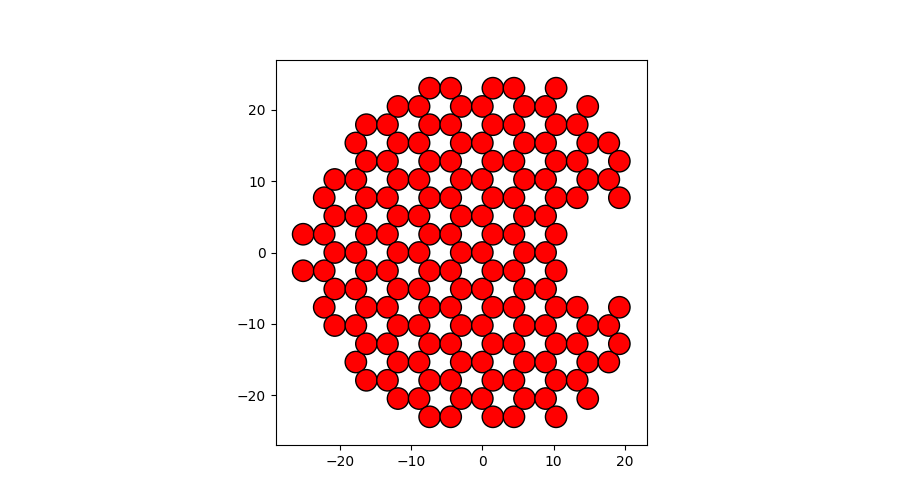

In [3]:
honeyComb = StackGeometry(15, PITCH)
# honeyComb.build_honeycomb_lattice()
# honeyComb.trim_lattice_to_fibre()
honeyComb.add_cores_from_file(core_file_path) 
honeyComb.show_fibre_design()

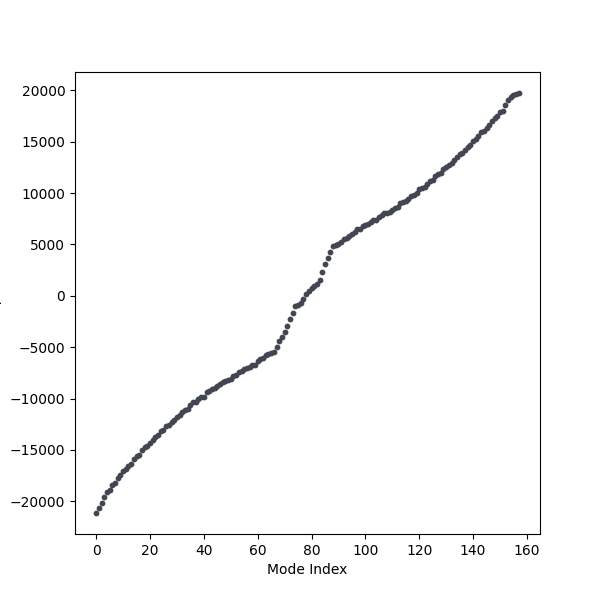

In [4]:
honeyCombAnalysisVector = AnalysisClass(honeyComb.coreLocations, 9144635.4, 1000, 7000, PITCH)
honeyCombAnalysisVector.find_twisted_eigenvalues_vector(with_onsite=True)
honeyCombAnalysisVector.plot_propagation_const()

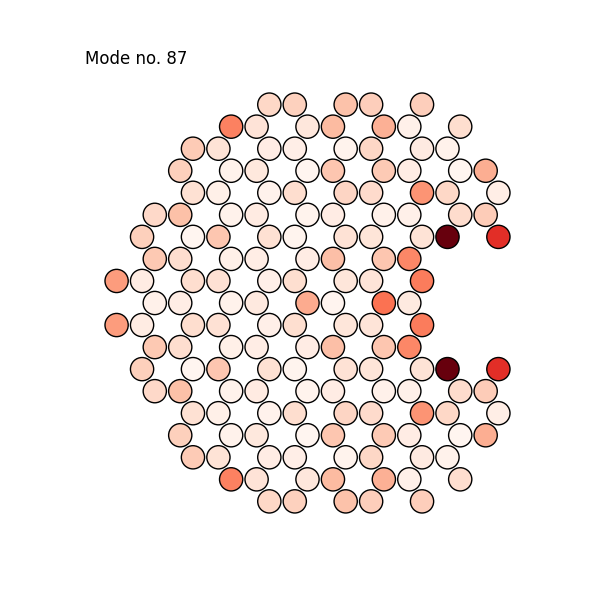

In [5]:
honeyCombAnalysisVector.plot_eigenmode(87)

(0.29099069643886705+7.667515632126009e-19j)


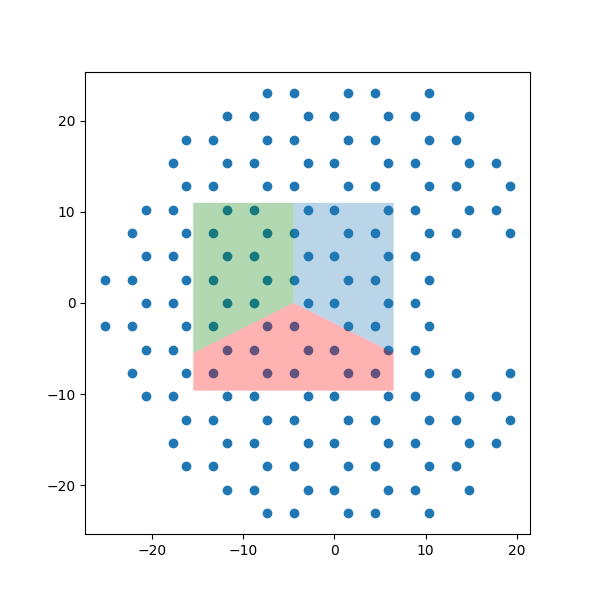

In [6]:
print(honeyCombAnalysisVector.real_space_chern_calc(91, -1, 11, -4.5))
honeyCombAnalysisVector.show_ABC_sections(11,-4.5)

In [8]:
partial_twist_chern_func = partial(honeyCombAnalysisVector.twisted_chern_sweep, starting_band=85, selection_size=11, shift=-4.5)
partial_twist_chern_c1_func = partial(honeyCombAnalysisVector.twisted_chern_c1_sweep, starting_band=85, selection_size=11, shift=-4.5)


coupling_list = np.linspace(100, 10000, 200)
twist_list = np.linspace(0,2500,200)
with Pool() as mp_pool:
    chern_vals = mp_pool.map(partial_twist_chern_func, twist_list)
with Pool() as mp_pool:
    chern_vals_c1 = mp_pool.map(partial_twist_chern_c1_func, coupling_list)


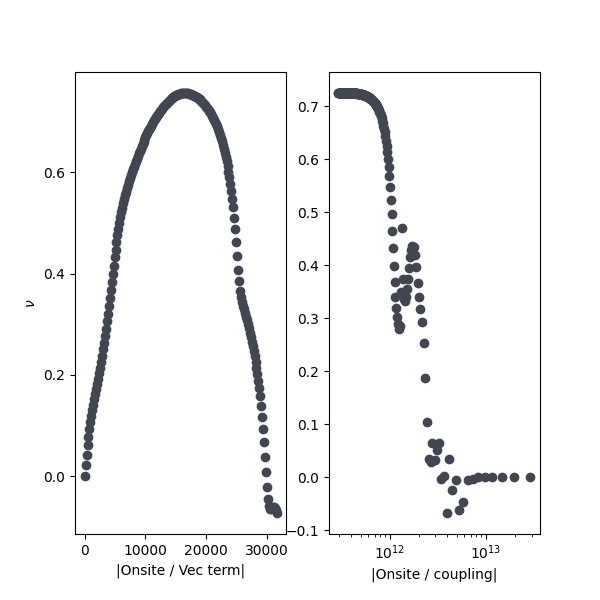

In [9]:
R_max_real = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyComb.coreLocations])
onsite_over_vec = twist_list*R_max_real/2
onsite_over_coupling = 1000**2 * R_max_real**2 * 9144635.4/ (2* coupling_list) 

fig_chern_change_twist = plt.figure(figsize=(6,6))
ax_chern_change_twist = fig_chern_change_twist.add_subplot(121)
ax_chern_change_c1 = fig_chern_change_twist.add_subplot(122)
ax_chern_change_twist.scatter(onsite_over_vec, np.real(chern_vals), color='#424651')
ax_chern_change_c1.scatter(onsite_over_coupling, np.real(chern_vals_c1), color='#424651')
ax_chern_change_c1.set_xscale('log')
ax_chern_change_twist.set_ylabel(r'$\nu$')
ax_chern_change_twist.set_xlabel('|Onsite / Vec term|')
ax_chern_change_c1.set_xlabel('|Onsite / coupling|')
# fig_chern_change_twist.savefig('twisted_fibre_chern.svg', dpi=300)
plt.show()

In [64]:

coupling_list_2 = np.arange(0,8000,100)
twist_list_for_heatmap = np.arange(0.0,1600,20)

array_for_plotting = np.zeros((len(coupling_list_2), len(twist_list_for_heatmap)))

for num in range(len(coupling_list_2)):
    honeyCombAnalysisVector.couplingStrength = coupling_list_2[num]
    partial_twist_chern_in_loop = partial(honeyCombAnalysisVector.twisted_chern_sweep, starting_band=85, selection_size=11, shift=-4.5)
    
    with Pool() as mp_pool:
        chern_vals_loop = mp_pool.map(partial_twist_chern_in_loop, twist_list_for_heatmap)
    array_for_plotting[num,:] = np.real(chern_vals_loop)



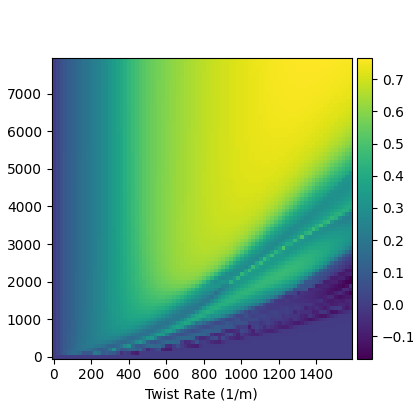

In [94]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
cm = 1/2.54
heatmap_fig = plt.figure(figsize=(10.5*cm,10.5*cm))
heatmap_ax = heatmap_fig.add_subplot(111)
# twood_array = np.reshape(threed_array,(25,3))

onsite_over_coupling = twist_list_for_heatmap**2 * R_max_real**2 / coupling_list_2
# XX,YY = np.meshgrid(twood_array[:,1],twood_array[:,2])

im = heatmap_ax.imshow(array_for_plotting, interpolation="nearest")

# print(coupling_list_2)
# print(twist_list_for_heatmap)
heatmap_ax.set_yticks(np.arange(len(coupling_list_2))[::10])
heatmap_ax.set_xticks(np.arange(len(twist_list_for_heatmap))[::10])
heatmap_ax.set_xticklabels(['{:.0f}'.format(i) for i in twist_list_for_heatmap[::10]])
heatmap_ax.set_yticklabels(['{:.0f}'.format(i) for i in coupling_list_2[::10]])
heatmap_ax.set_xlabel('Twist Rate (1/m)')
heatmap_ax.set_ylabel('Coupling Strength (1/m)')
heatmap_ax.invert_yaxis()
heatmap_ax.set_aspect('equal')
# ax = plt.gca()

divider = make_axes_locatable(heatmap_ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = heatmap_ax.figure.colorbar(im, ticks=np.arange(-0.2, 1.1, 0.1), cax=cax)
cbar.ax.set_ylabel('Chern Number', rotation=-90, va="bottom")
heatmap_fig.savefig('../Twisted Fibre/heatmap realistic system.svg', dpi=600)
plt.show()

## Now looking at uniform lattices of different sizes

46.57252408878007


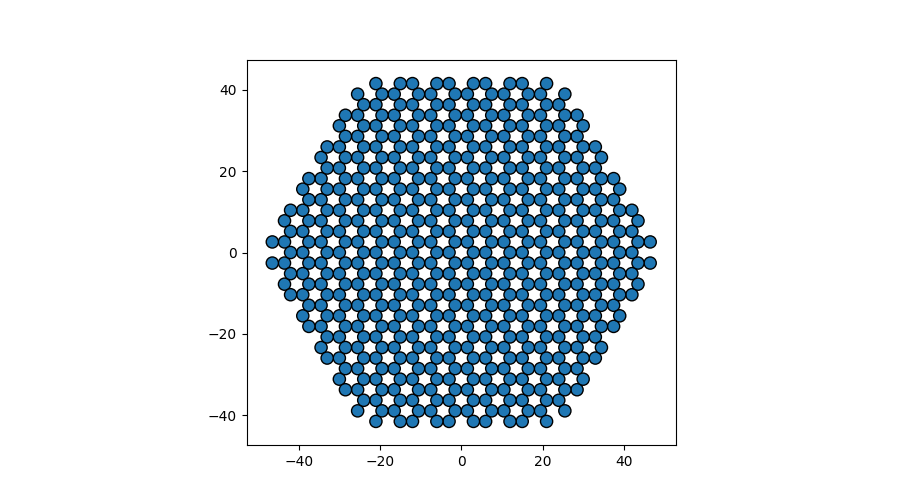

In [19]:
honeyCombUniform = StackGeometry(16, PITCH)
honeyCombUniform.build_honeycomb_lattice()
honeyCombUniform.trim_lattice_to_fibre()
print(np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyCombUniform.latticePoints]))
honeyCombUniform.show_fibre_design()

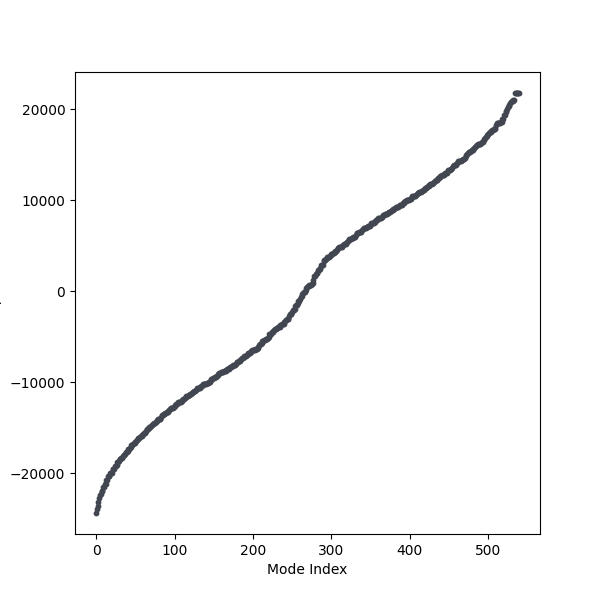

In [20]:
honeyCombUniform = AnalysisClass(honeyCombUniform.latticePoints, 9144635.4, 1000, 7000, PITCH)
honeyCombUniform.find_twisted_eigenvalues_vector(with_onsite=True)
honeyCombUniform.plot_propagation_const()

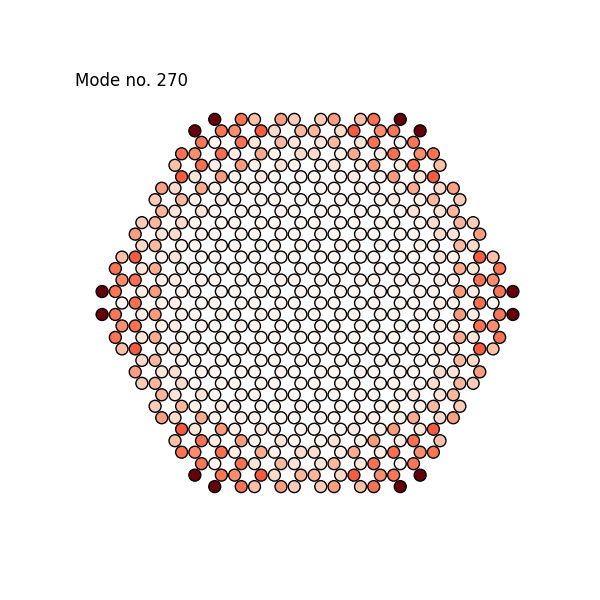

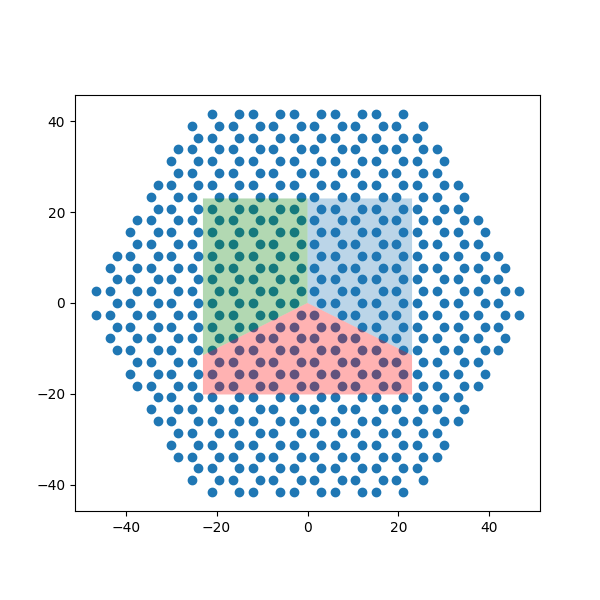

In [28]:
honeyCombUniform.plot_eigenmode(270)
honeyCombUniform.show_ABC_sections(23,0)

In [55]:

twist_list = np.linspace(0,1500,100)

In [56]:
honeyCombUniform8 = StackGeometry(8, PITCH)
honeyCombUniform8.build_honeycomb_lattice()
honeyCombUniform8.trim_lattice_to_fibre()
honeyCombUniform8analysis = AnalysisClass(honeyCombUniform8.latticePoints, 9144635.4, 1000, 7000, PITCH)
partial_twist_chern_func = partial(honeyCombUniform8analysis.twisted_chern_sweep, starting_band=74, selection_size=13, shift=0)
with Pool() as mp_pool:
    chern_vals8 = mp_pool.map(partial_twist_chern_func, twist_list)
R_8 = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyCombUniform8.latticePoints])*1e-6

In [57]:
honeyCombUniform10 = StackGeometry(10, PITCH)
honeyCombUniform10.build_honeycomb_lattice()
honeyCombUniform10.trim_lattice_to_fibre()
honeyCombUniform10analysis = AnalysisClass(honeyCombUniform10.latticePoints, 9144635.4, 1000, 7000, PITCH)
partial_twist_chern_func = partial(honeyCombUniform10analysis.twisted_chern_sweep, starting_band=117, selection_size=16, shift=0)
with Pool() as mp_pool:
    chern_vals10 = mp_pool.map(partial_twist_chern_func, twist_list)

R_10 = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyCombUniform10.latticePoints])*1e-6

In [58]:
honeyCombUniform12 = StackGeometry(12, PITCH)
honeyCombUniform12.build_honeycomb_lattice()
honeyCombUniform12.trim_lattice_to_fibre()
honeyCombUniform12analysis = AnalysisClass(honeyCombUniform12.latticePoints, 9144635.4, 1000, 7000, PITCH)
partial_twist_chern_func = partial(honeyCombUniform12analysis.twisted_chern_sweep, starting_band=165, selection_size=18, shift=0)
with Pool() as mp_pool:
    chern_vals12 = mp_pool.map(partial_twist_chern_func, twist_list)

R_12 = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyCombUniform12.latticePoints])*1e-6

In [59]:
honeyCombUniform14 = StackGeometry(14, PITCH)
honeyCombUniform14.build_honeycomb_lattice()
honeyCombUniform14.trim_lattice_to_fibre()
honeyCombUniform14analysis = AnalysisClass(honeyCombUniform14.latticePoints, 9144635.4, 1000, 7000, PITCH)
partial_twist_chern_func = partial(honeyCombUniform14analysis.twisted_chern_sweep, starting_band=217, selection_size=20, shift=0)
with Pool() as mp_pool:
    chern_vals14 = mp_pool.map(partial_twist_chern_func, twist_list)

R_14 = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyCombUniform14.latticePoints])*1e-6

In [60]:
honeyCombUniform16 = StackGeometry(16, PITCH)
honeyCombUniform16.build_honeycomb_lattice()
honeyCombUniform16.trim_lattice_to_fibre()
honeyCombUniform16analysis = AnalysisClass(honeyCombUniform16.latticePoints, 9144635.4, 1000, 7000, PITCH)
partial_twist_chern_func = partial(honeyCombUniform16analysis.twisted_chern_sweep, starting_band=270, selection_size=23, shift=0)
with Pool() as mp_pool:
    chern_vals16 = mp_pool.map(partial_twist_chern_func, twist_list)

R_16 = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyCombUniform16.latticePoints])*1e-6

In [33]:


# chern_list = []
# twist_list = np.linspace(0,1800,100)
# for i in np.arange(8,18,2):
#     honeyCombUniformTemp = StackGeometry(i, PITCH)
#     honeyCombUniformTemp.build_honeycomb_lattice()
#     honeyCombUniformTemp.trim_lattice_to_fibre()
#     honeyCombUniformTemp = AnalysisClass(honeyCombUniformTemp.latticePoints, 9144635.4, 1000, 7000, PITCH)
#     partial_twist_chern_func = partial(honeyCombUniformTemp.twisted_chern_sweep, starting_band=74, selection_size=13, shift=0)
#     with Pool() as mp_pool:
#         chern_vals = mp_pool.map(partial_twist_chern_func, twist_list)
#     chern_list.append(chern_vals)

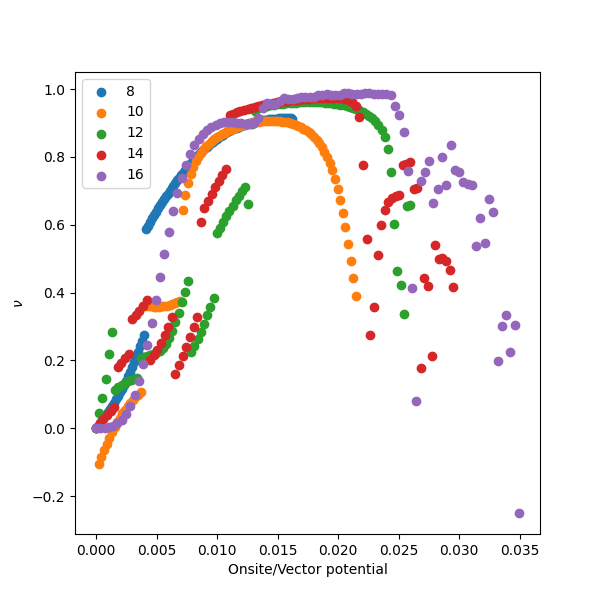

In [63]:
fig_chern_diff_size = plt.figure(figsize=(6,6))
ax_chern_diff_size = fig_chern_diff_size.add_subplot(111)
# for n,s in enumerate(chern_list):
#     print(s)
ax_chern_diff_size.scatter((twist_list*R_8)/2, np.real(chern_vals8), label='8')
ax_chern_diff_size.scatter((twist_list*R_10)/2, np.real(chern_vals10), label='10')
ax_chern_diff_size.scatter((twist_list*R_12)/2, np.real(chern_vals12), label='12')
ax_chern_diff_size.scatter((twist_list*R_14)/2, np.real(chern_vals14), label='14')
ax_chern_diff_size.scatter((twist_list*R_16)/2, np.real(chern_vals16), label='16')
ax_chern_diff_size.set_ylabel(r'$\nu$')
ax_chern_diff_size.set_xlabel('Onsite/Vector potential')
# fig_chern_change_twist.savefig('twisted_fibre_chern.svg', dpi=300)
plt.legend()
plt.show()

## plotting chern number heatmap with onsite and vector terms on axes 

In [11]:
print(R_max_real**2  /2)

319.3663860992925


In [6]:
R_max_real = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyComb.coreLocations])
twist_list_for_heatmap = np.linspace(0.01,1600,20)
x_axis = twist_list_for_heatmap* R_max_real/2
y_axis = np.linspace(1e11, 1e13, 20)
# print(y_axis)
beta_0 = 9144635.4


array_for_plotting = np.zeros((len(y_axis), len(x_axis)))

for indx, numx in enumerate(x_axis):
    print(indx)
    for indy, numy in enumerate(y_axis): 

        coupling_temp = 2*numx**2 * beta_0 / numy
        array_for_plotting[indx, indy] = np.real(honeyCombAnalysisVector.twisted_chern_both_sweep(twist_list_for_heatmap[indx], coupling_temp, starting_band=85, selection_size=11, shift=-4.5))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
print(array_for_plotting)

In [ ]:

cm = 1/2.54
heatmap_fig_theory = plt.figure(figsize=(10.5*cm,10.5*cm))
heatmap_ax_theory = heatmap_fig_theory.add_subplot(111)
# twood_array = np.reshape(threed_array,(25,3))


# XX,YY = np.meshgrid(twood_array[:,1],twood_array[:,2])

im = heatmap_ax_theory.imshow(array_for_plotting, interpolation="nearest")

# print(coupling_list_2)
# print(twist_list_for_heatmap)
heatmap_ax_theory.set_yticks(np.arange(len(y_axis))[::5])
heatmap_ax_theory.set_xticks(np.arange(len(x_axis))[::5])
heatmap_ax_theory.set_xticklabels(['{:.0f}'.format(i) for i in x_axis[::5]])
heatmap_ax_theory.set_yticklabels(['{:.0f}'.format(i) for i in y_axis[::5]])
heatmap_ax_theory.set_xlabel('Onsite/Vec')
heatmap_ax_theory.set_ylabel('Onsite / Coupling Strength')
heatmap_ax_theory.invert_yaxis()
heatmap_ax_theory.set_aspect('equal')
# ax = plt.gca()

divider = make_axes_locatable(heatmap_ax_theory)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = heatmap_ax_theory.figure.colorbar(im, ticks=np.arange(-0.2, 1.1, 0.1), cax=cax)
cbar.ax.set_ylabel('Chern Number', rotation=-90, va="bottom")
# heatmap_fig.savefig('../Twisted Fibre/heatmap realistic system.svg', dpi=600)
plt.show()

1.09 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


2.5273163082578027e-05


<ipython-input-54-df2d5d8f804e>:4: RuntimeWarning: divide by zero encountered in true_divide
  vec_onsite_ratio = 2/(twist_list*R_max_real)


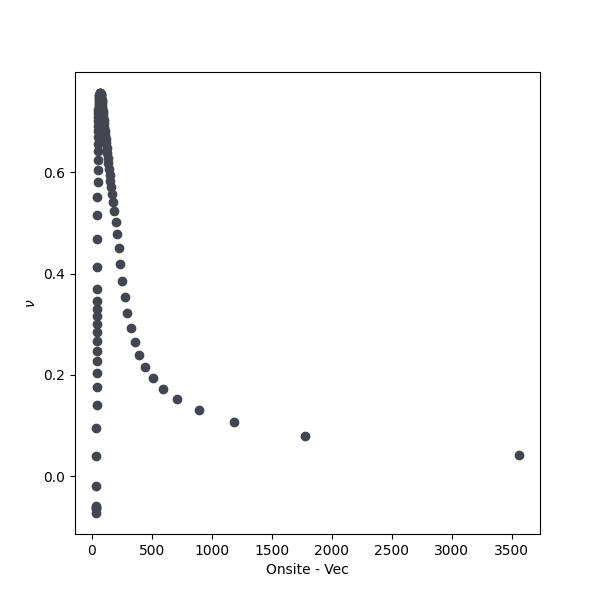

In [ ]:
R_max_real = np.max([np.sqrt(i[0]**2 + i[1]**2) for i in honeyComb.coreLocations])*1e-6
print(R_max_real)
onsite_v_vec = (twist_list**2 * R_max_real**2)/2 - twist_list*R_max_real
vec_onsite_ratio = 2/(twist_list*R_max_real)
fig_chern_change_twist = plt.figure(figsize=(6,6))
ax_chern_change_twist = fig_chern_change_twist.add_subplot(111)
ax_chern_change_twist.scatter(vec_onsite_ratio, np.real(chern_vals), color='#424651')
ax_chern_change_twist.set_ylabel(r'$\nu$')
ax_chern_change_twist.set_xlabel('Onsite - Vec')
# fig_chern_change_twist.savefig('twisted_fibre_chern.svg', dpi=300)
plt.show()